In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras import backend as K

In [64]:
X_train=np.loadtxt('training_data/Xtrain_seg_mask.csv',delimiter=',')
Y_train=np.loadtxt('training_data/Ytrain_seg_mask.csv',delimiter=',')

Y_train=Y_train.reshape(len(Y_train),4800,2)


In [65]:
X_train=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in X_train])


In [66]:
Xtrain, Xtest, Ytrain, Ytest= train_test_split(X_train, Y_train, test_size=0.2)
print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)



(3409, 4800) (3409, 4800, 2) (853, 4800) (853, 4800, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

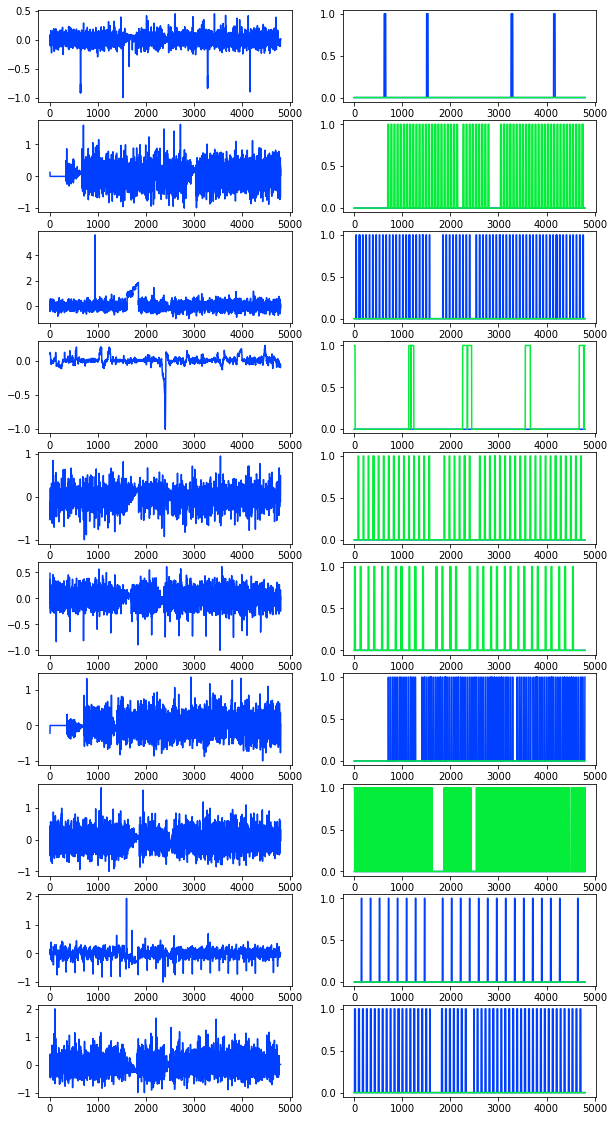

In [67]:

vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,2,figsize=(10,20))
for i in range(0,10):
    ax[i][0].plot(Xtrain[vararr[i]])
    ax[i][1].plot(Ytrain[vararr[i],:,0])
    ax[i][1].plot(Ytrain[vararr[i],:,1])
plt.show


In [69]:


def dice_coeff(y_true, y_pred):
    smooth = 1.
    sh = tf.shape(y_true)
    y_true_int = tf.reshape(y_true, [sh[0], sh[1]*sh[2]])
    y_pred_int = tf.reshape(y_pred, [sh[0], sh[1]*sh[2]])
    w = 1 - tf.reduce_sum(y_true,(1,2)) / 9600.
    w = tf.reshape(w, [len(w),1])
    # Flatten
    y_true_f = tf.reshape(tf.multiply(y_true_int,w), [-1])
    y_pred_f = tf.reshape(tf.multiply(y_pred_int,w), [-1])
    #y_pred_int_f = tf.reshape(tf.matmul(w, y_pred_int), [-1])
    #y_true_f = tf.reshape(y_true, [-1])
    y_pred_f_2 = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f_2)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + generalized_dice_coeff(y_true, y_pred)
    return loss



def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(Ytest,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w  + 0.00001)
    w=tf.cast(w,tf.float32)
    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

In [118]:
IMG_SIZE=4800
#add hidden layers
conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
#xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
xi=keras.layers.BatchNormalization()(xi)

x1=keras.layers.Conv1D(32,kernel_size=3,strides=2,activation='tanh',padding='same',name='second_conv32_5')(xi)
c1=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv32_5')(x1)    #2400,32

x2=keras.layers.BatchNormalization()(c1)
x2=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(x2)   
x2=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='first_conv64_5')(x2)
c2=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv64_5')(x2) #size 1200,64

x3=keras.layers.BatchNormalization()(c2)
x3=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_2')(x3)   
x3=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='first_conv128_5')(x3)
c3=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv128_5')(x3) #size 600,128

x4=keras.layers.BatchNormalization()(c3)
x4=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_3')(x4)    
x4=keras.layers.Conv1D(256,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv256_5')(x4)#size 300,256
#x4=keras.layers.Flatten()(x4)
#x4 = keras.layers.Dense(256,activation='relu')(x4)
#x4 = keras.layers.Dense(300*128,activation='relu')(x4)
#x4=keras.layers.Reshape((300,128))(x4)


x4 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', padding="same", strides=2, name="dec_conv_tran128_5")(x4)#600,128
x4 =keras.layers.BatchNormalization()(x4)

x5 = keras.layers.Concatenate(axis=2)([c3,x4])
x5 = keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv128_5')(x5)
x5 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding="same", strides=2, name="dec_conv_tran64_1")(x5)
x5 = keras.layers.BatchNormalization()(x5)  #1200,64

x6 = keras.layers.Concatenate(axis=2)([c2,x5]) 
x6 = keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv64_2')(x6) #1200,64
x6 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding="same", strides=2, name="dec_conv_tran32_5")(x6)
x6 = keras.layers.BatchNormalization()(x6)  #2400,32

x7 = keras.layers.Concatenate(axis=2)([c1,x6]) 
x7 = keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv32_5')(x7) #1200,64
x7 = keras.layers.Conv1DTranspose(1,kernel_size=3,strides=2,padding='same',name='semiop2',activation='relu')(x7)
conv_op = keras.layers.Conv1D(2,kernel_size=3,strides=1,padding='same',name='semiop',activation='sigmoid')(x7)

#conv_op=keras.layers.Reshape((IMG_SIZE, ), input_shape=(IMG_SIZE,1),name='reshape_2')(x6)



keras.backend.clear_session()
#convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')

convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')


convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), loss=bce_dice_loss)

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 4800)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4800, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4800, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
second_conv32_5 (Conv1D)        (None, 2400, 32)     128         batch_normalization[0][0]        
___________________________________________________________________________________

In [7]:
'''
IMG_SIZE=6000
#add hidden layers
conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
#xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
xi=keras.layers.BatchNormalization()(xi)

x1=keras.layers.Conv1D(16,kernel_size=5,strides=3,activation='tanh',padding='same',name='second_conv16_5')(xi)
x1=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv16_5')(x1)
x1=keras.layers.BatchNormalization()(x1)
c1=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_1')(x1)   #size 1000

x2=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv32_5')(c1)
x2=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv32_5')(x2)
x2=keras.layers.BatchNormalization()(x2)
c2=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_2')(x2)    #size 500

ao = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_1")(c2)
ao = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_2")(ao)
ao=keras.layers.Flatten()(ao)
ao=keras.layers.Dense(200,activation='tanh',name='adding_this')(ao)

x3=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv64_5')(c2)
x3=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv64_5')(x3)
x3=keras.layers.BatchNormalization()(x3)
x3=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_3')(x3)    #size 250

x3=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv128_5')(x3)
x3=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv128_5')(x3)
x3=keras.layers.BatchNormalization()(x3)
x3=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_4')(x3)    #size 125


x3 = keras.layers.Conv1DTranspose(filters=64, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_1")(x3)
x3 = keras.layers.Conv1DTranspose(filters=64, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_2")(x3)

x3 = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_3")(x3)
x3 = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_4")(x3)
tx2 = keras.layers.Concatenate(axis=1)([c2,x3]) #size=400
tx2 = keras.layers.Conv1D(32,kernel_size=3,strides=2,activation='tanh',padding='same',name='maxpoolt_2')(tx2)
tx2=keras.layers.BatchNormalization()(tx2)

#tx2 = keras.layers.Conv1DTranspose(filters=16, kernel_size=5, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_5")(tx2)
#tx2 = keras.layers.Conv1DTranspose(filters=16, kernel_size=5  , activation='tanh', padding="same", strides=1, name="decoder_conv_tran_6")(tx2)

tx2=keras.layers.Flatten()(x3)
tx2=keras.layers.Dense(128,activation='relu')(tx2)
tx2=keras.layers.Dense(128,activation='relu')(tx2)
tx2=keras.layers.Dense(1,activation='relu')(tx2)
conv_op=keras.layers.Dense(2,activation='softmax',name='missing_this')(tx2)



#convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')
convNN = keras.Model(inputs=conv_ip, outputs=[ao,conv_op],name='Convolutional_NN')


convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000005), 
    loss={'missing_this': 'categorical_crossentropy','adding_this':keras.losses.Huber(delta=0.1)},metrics={'missing_this':'accuracy'})'''
print(' ')

In [111]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=convNN.fit(np.asarray(Xtrain),np.asarray(Ytrain), batch_size=64, epochs=15  , verbose=1, 
     validation_split=0.15)
#history=convNN.fit(np.array(Xtrain),[np.array(Itrain),np.array(Ytrain)], batch_size=64, epochs=70 , verbose=1 ,
#    shuffle=True,validation_split=0.2)

Epoch 1/25
46/46 [==============================] - 53s 1s/step - loss: 1.5512 - val_loss: 1.5573
Epoch 2/25
46/46 [==============================] - 47s 1s/step - loss: 1.5403 - val_loss: 1.5536
Epoch 3/25
46/46 [==============================] - 47s 1s/step - loss: 1.5327 - val_loss: 1.5462
Epoch 4/25
46/46 [==============================] - 47s 1s/step - loss: 1.5263 - val_loss: 1.5369
Epoch 5/25
46/46 [==============================] - 47s 1s/step - loss: 1.5204 - val_loss: 1.5275
Epoch 6/25
46/46 [==============================] - 47s 1s/step - loss: 1.5146 - val_loss: 1.5190
Epoch 7/25
46/46 [==============================] - 47s 1s/step - loss: 1.5088 - val_loss: 1.5111
Epoch 8/25
46/46 [==============================] - 47s 1s/step - loss: 1.5031 - val_loss: 1.5041
Epoch 9/25
46/46 [==============================] - 47s 1s/step - loss: 1.4974 - val_loss: 1.4980
Epoch 10/25
46/46 [==============================] - 47s 1s/step - loss: 1.4917 - val_loss: 1.4921
Epoch 11/25
46/46 [

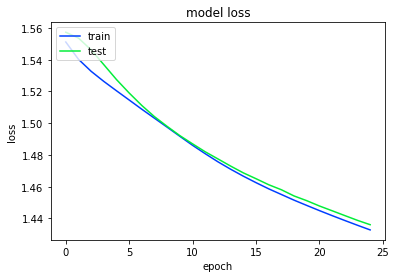

In [112]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('present_segment.png')
plt.show()

Text(0.5, 0, 'Phase')

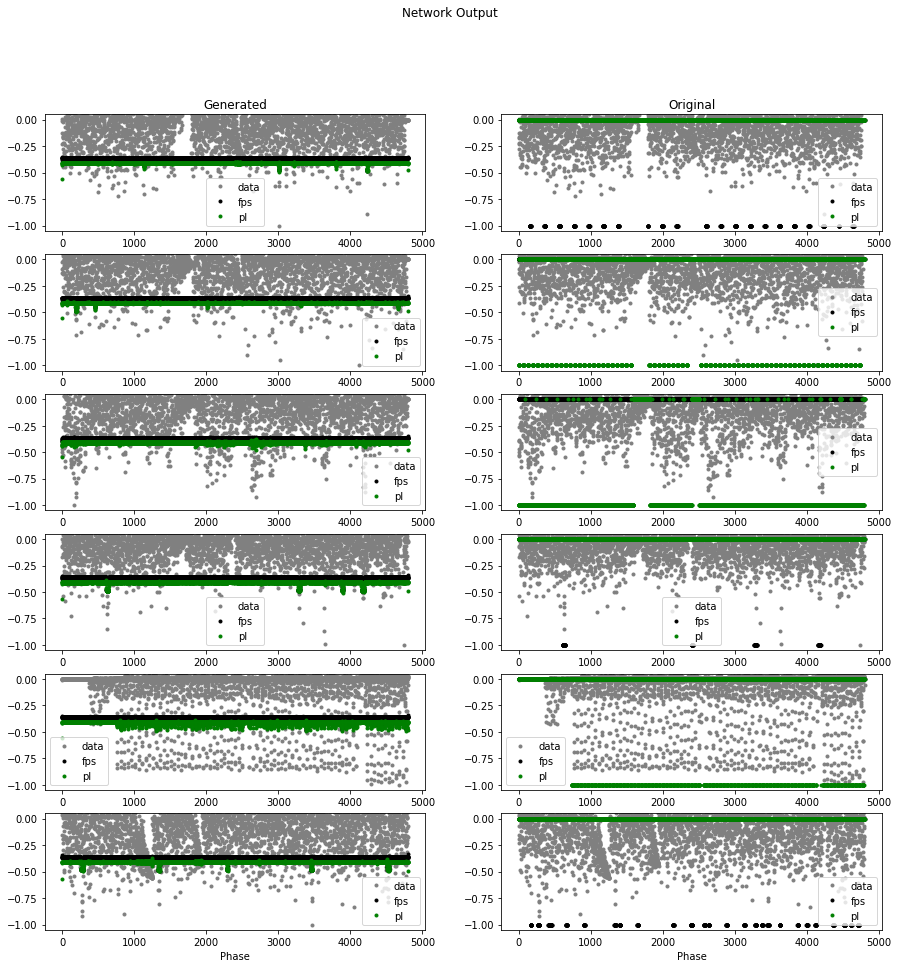

In [117]:

from sklearn.metrics import mean_squared_error
#convNN.load_weights('long_hard_battle_eq.h5')
pred_op=convNN.predict(np.array(Xtest))

fig,ax=plt.subplots(6,2,figsize=(15,15))
plt.style.use('seaborn-bright')
plt.suptitle('Network Output')
ar=np.random.randint(len(Xtest),size=10)
#ar=[0,1,2,3,8,7]
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,6):
    ax[i][0].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='data')
    ax[i][0].plot(-pred_op[ar[i],:,0],color='black',ls='None',marker='.',label='fps')
    ax[i][0].plot(-pred_op[ar[i],:,1],color='green',ls='None',marker='.',label='pl')
    
    
    ax[i][1].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='data')
    ax[i][1].plot(-Ytest[ar[i],:,0],color='black',ls='None',marker='.',label='fps')
    ax[i][1].plot(-Ytest[ar[i],:,1],color='green',ls='None',marker='.',label='pl')
    
    #ax[i][1].plot(pred_op_mod[ar[i]],color='black',ls='None',marker='.')
    ax[i][0].legend('flux')
    ax[i][0].set_ylim(-1.05,0.05)
    ax[i][1].set_ylim(-1.05,0.05)
    ax[i][0].legend()
    ax[i][1].legend()
ax[5][0].set_xlabel('Phase')
ax[5][1].set_xlabel('Phase')

#plt.savefig('present_itsamust')


In [108]:
class_Ytest=[]
class_Ypred=[]
for el in pred_op:
    pl=np.array(el[:,0]>0.20).sum()
    fps=np.array(el[:,1]>0.35).sum()
    if(pl>fps):class_Ypred.append(1)
    else: class_Ypred.append(0)

for el in Ytest:
    pl=np.array(el[:,0]>0.20).sum()
    fps=np.array(el[:,1]>0.35).sum()
    if(pl>fps):class_Ytest.append(1)
    else: class_Ytest.append(0)
    #4800,2
#[print(class_Ypred[i],class_Ytest[i]) for i in range(0,len(class_Ytest))]

cm=confusion_matrix(class_Ytest,class_Ypred)
print(cm)

[[364 182]
 [ 74 233]]


In [106]:
#different approach to CM
class_Ytest=[]
class_Ypred=[]
for el in pred_op:
    pl=np.array(el[:,0]>0.20).sum()
    fps=np.array(el[:,1]>0.30).sum()
    if(pl>3*fps):class_Ypred.append([1,0])
    elif(fps>3*pl):class_Ypred.append([0,1])
    else: class_Ypred.append([1,1])

for el in Ytest:
    pl=np.array(el[:,0]>0.20).sum()
    fps=np.array(el[:,1]>0.30).sum()
    if(pl*fps):class_Ytest.append([1,1])
    elif(pl):class_Ytest.append([1,0])
    else: class_Ytest.append([0,1])
    #4800,2
#[print(class_Ypred[i],class_Ytest[i]) for i in range(0,len(class_Ytest))]


cm=confusion_matrix(np.asarray(class_Ytest)[:,0],np.asarray(class_Ypred)[:,0])
print(cm)

[[296 238]
 [ 45 274]]


0.712812160694897
(3,) (3,) (3,)


Text(0, 0.5, 'True Positive Rate')

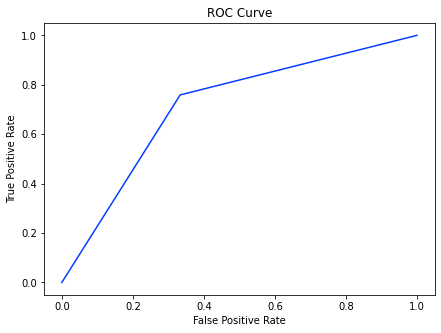

In [109]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

fpr , tpr, thes= roc_curve(class_Ytest,class_Ypred,pos_label=1)
print(auc(fpr,tpr))
print(fpr.shape,tpr.shape,thes.shape)
plt.style.use('seaborn-bright')
plt.figure(figsize=(7,5))
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [11]:
mask_train=convNN.predict(np.array(Xtrain))
mask_test=convNN.predict(np.array(Xtest))
mask_train=np.asarray([[1 if max(el[0],el[1])>0.3 else 0 for el in x ] for x in mask_train])
mask_test=np.asarray([[1 if max(el[0],el[1])>0.3 else 0 for el in x ] for x in mask_test])
Itrain=Xtrain*mask_train
Itest=Xtest*mask_test
cltrain=[]
cltest=[]

for el in Ytrain:
    pl=np.array(el[:,0]>0.5).sum()
    fps=np.array(el[:,1]>0.5).sum()
    if(pl>fps):cltrain.append([1,0])
    else: cltrain.append([0,1])

for el in Ytest:
    pl=np.array(el[:,0]>0.5).sum()
    fps=np.array(el[:,1]>0.5).sum()
    if(pl>fps):cltest.append([1,0])
    else: cltest.append([0,1])

print(np.asarray(Itrain).shape,np.asarray(cltrain).shape)

(2492, 4800) (2492, 2)


In [12]:
mask_test=convNN.predict(np.array(Xtest))
mask_test=np.asarray([[1 if max(el[0],el[1])>0.5 else 0 for el in x ] for x in mask_test])
mask_test_true=np.asarray([[1 if max(el[0],el[1])>0.5 else 0 for el in x ] for x in Ytest])

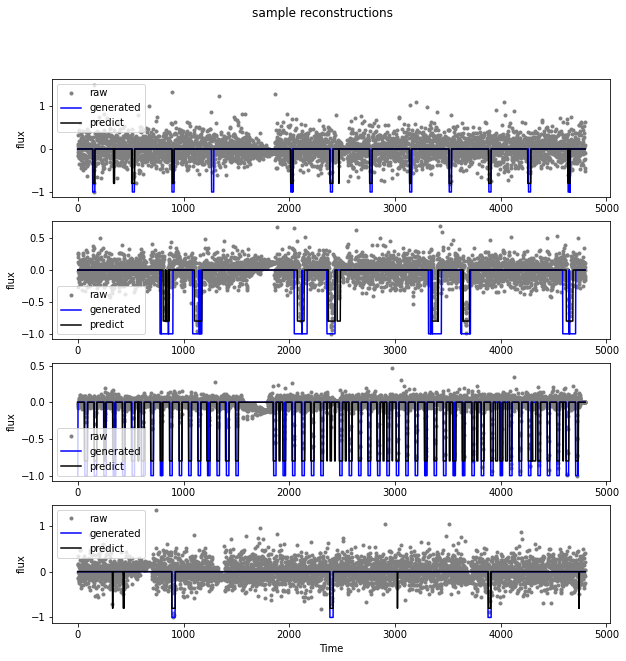

In [19]:
def smoothbin(arr):
    for m in range(5,len(arr)-5):
        if(arr[m]==0):
            if(arr[m-1]==-1 and arr[m+1]==-1): 
                arr[m]=-1
            elif(arr[m-2]==-1 and arr[m+2]==-1): 
                arr[m]=-1
            elif(arr[m-3]==-1 and arr[m+3]==-1): 
                arr[m]=-1
            elif(arr[m-4]==-1 and arr[m+4]==-1): 
                arr[m]=-1
            elif(arr[m-5]==-1 and arr[m+5]==-1): 
                arr[m]=-1
    return arr

fig,ax=plt.subplots(4,1,figsize=(10,10))
plt.style.use('seaborn-bright')
plt.suptitle('sample reconstructions')
#ar=np.random.randint(len(Xtest),size=5)
ar=[0,7,2,3]

for i in range(0,4):
    ax[i].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='raw')
    ax[i].plot(mask_test_true[ar[i]]*min(Xtest[ar[i]]),color='blue',ls='-',label='generated')
    ax[i].plot(smoothbin(mask_test[ar[i]])*min(Xtest[ar[i]])*0.8,color='black',label='predict')
    ax[i].legend()
    ax[i].set_ylabel('flux')
    #ax[i][1].plot(pred_op_mod[ar[i]],color='black',ls='None',marker='.')
    
    #ax[i][0].legend()
ax[3].set_xlabel('Time')
plt.savefig('present_rec.png')

In [34]:
convNN.save_weights('long_hard_battle_eq.h5')
convNN.save('Model_long_hard_battle_eq.h5')

<function matplotlib.pyplot.show(close=None, block=None)>

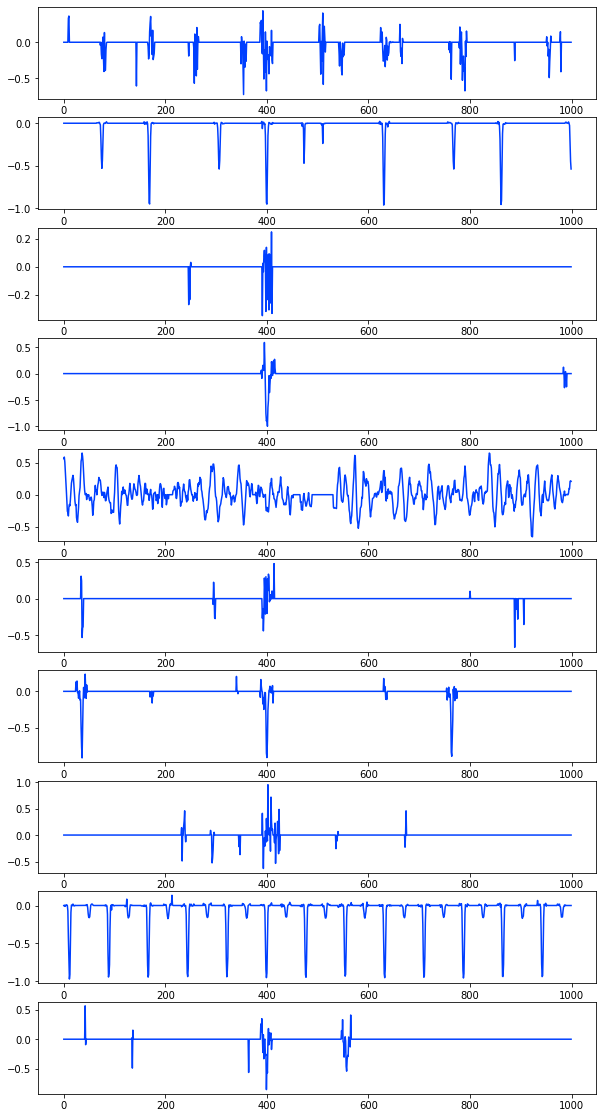

In [38]:

vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,1,figsize=(10,20))
for i in range(0,10):
    ax[i].plot( Itrain[vararr[i]][2000:3000],label=Ytrain[vararr[i]])
plt.show

In [41]:
IM_SIZE=4800
#add hidden layers
class_ip = keras.layers.Input(shape=(IM_SIZE,),name='Input')

m=keras.layers.Reshape((IM_SIZE, 1), input_shape=(IM_SIZE,),name='reshape_1')(class_ip)
m=keras.layers.BatchNormalization()(m)
m=keras.layers.Conv1D(16,kernel_size=3,strides=2,activation='tanh',padding='same',name='second_conv16_5')(m)
m=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv16_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(m)
m=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv32_5')(m)
m=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv32_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_2')(m)
m=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv64_5')(m)
m=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv64_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_4')(m)
m=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv128_5')(m)
m=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv128_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_3')(m)
m=keras.layers.Flatten(name='flat_1')(m)
m=keras.layers.Dense(256,name='dense_layer_3',activation='relu')(m)
m=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(m)
m=keras.layers.Dense(256,name='dense_layer_7',activation='relu')(m)
m=keras.layers.Dense(1,name='dense_layer_4',activation='relu')(m)
class_op=keras.layers.Dense(2,name='dense_layer_6',activation='softmax')(m)


#convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')
classify = keras.Model(inputs=class_ip, outputs=class_op,name='Classifier_NN')


classify.summary()
classify.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000005), loss='categorical_crossentropy',metrics=['accuracy'])

Model: "Classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 4800)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4800, 1)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4800, 1)           4         
_________________________________________________________________
second_conv16_5 (Conv1D)     (None, 2400, 16)          64        
_________________________________________________________________
third_conv16_5 (Conv1D)      (None, 2400, 16)          784       
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 1200, 16)          0         
_________________________________________________________________
second_conv32_5 (Conv1D)     (None, 1200, 32)        

In [42]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#history=convNN.fit([np.array(Xtrain),np.array(Xtrainl)],np.array(Ytrain), batch_size=64, epochs=40, verbose=VERBOSE, validation_split=0.12,callbacks=[es_callback])
history2=classify.fit(np.asarray(Itrain),np.asarray(cltrain), batch_size=64, epochs=40 , verbose=1 , shuffle=True,validation_split=0.15)

Epoch 1/40
49/49 [==============================] - 14s 233ms/step - loss: 0.6571 - accuracy: 0.6415 - val_loss: 0.6550 - val_accuracy: 0.6556
Epoch 2/40
49/49 [==============================] - 10s 211ms/step - loss: 0.6346 - accuracy: 0.6451 - val_loss: 0.6410 - val_accuracy: 0.6556
Epoch 3/40
49/49 [==============================] - 10s 211ms/step - loss: 0.6265 - accuracy: 0.6451 - val_loss: 0.6296 - val_accuracy: 0.6556
Epoch 4/40
49/49 [==============================] - 10s 211ms/step - loss: 0.6171 - accuracy: 0.6451 - val_loss: 0.6156 - val_accuracy: 0.6556
Epoch 5/40
49/49 [==============================] - 10s 211ms/step - loss: 0.6074 - accuracy: 0.6451 - val_loss: 0.6082 - val_accuracy: 0.6556
Epoch 6/40
49/49 [==============================] - 10s 211ms/step - loss: 0.5985 - accuracy: 0.6451 - val_loss: 0.5966 - val_accuracy: 0.6556
Epoch 7/40
49/49 [==============================] - 10s 211ms/step - loss: 0.5877 - accuracy: 0.6451 - val_loss: 0.5887 - val_accuracy: 0.6556

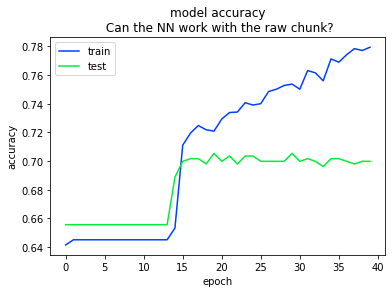

In [43]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy\n Can the NN work with the raw chunk?')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#  plt.savefig('rec_manual_mask.png')
plt.show()

In [46]:
test_loss, test_acc = classify.evaluate(np.array(Itest), np.array(cltest))
print('Test accuracy:', test_acc)
Ypred_raw=classify.predict(np.array(Itest))
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(cltest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

29/29 [==============================] - 1s 42ms/step - loss: 0.5939 - accuracy: 0.6674
Test accuracy: 0.6674033403396606
[[ 98 245]
 [ 56 506]]
